# Gibbs Sampler for Bayesian GMM 

### The Target Distribution

Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ is drawn from the mixture of $K$ number of Gaussian distributions. $X$ has D elements. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distribution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### Gibbs Sampler
The full conditionals are as follows:
1. $p(\mathbf{z}_{n} = \delta(k) | \mathbf{x}_n, \mu, \Sigma, \pi)  \propto \pi_k \mathcal{N}(\mathbf{x}_n | \mu_k, \Sigma_k)$.
2. $p(\pi|\mathbf{Z}) = \mathrm{Dir}(\{ \alpha_k + \sum_{i=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))_{k=1}^K\})$
3. $p(\mu_k | \Sigma_k, \mathbf{Z}, \mathbf{X}) = \mathcal{N}(\mu_k | m_k, V_k)$
4. $\mathbf{V}_k^{-1} = \mathbf{V}_0^{-1} + N_k\Sigma_k^{-1}$
5. $\mathbf{m}_k = \mathbf{V}_k(\Sigma_k^{-1}N_k\overline{\mathbf{x}}_k + \mathbf{V}_0^{-1}\mathbf{m}_0)$
6. $N_k = \sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))$
7. $\overline{\mathbf{x}}_k = \displaystyle \frac{\sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))\mathbf{x}_n}{N_k}$
8. $p(\Sigma_k | \mu_k, \mathbf{z}, \mathbf{x}) = IW(\Sigma_k | \mathbf{S}_k, \nu_k)$
9. $\mathbf{S}_k = \mathbf{S}_0 + \sum_{n=1}^N \mathbb{I}(\mathbf{z}_{n} = \delta(k))(\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^\top$
10. $\nu_k = \nu_0 + N_k$

The algorithm for the sampler is as follows:
1. Instantiate the latent variables randomly.
2. For $k=1...K$:
    3. For $n=1...N$: update $z_i$ by sampling from $p(\mathbf{z}_{n} = \delta(k) | \mathbf{x}_n, \mu, \Sigma, \pi)$.
    4. Update $\pi$
    5. Update variables for each component 

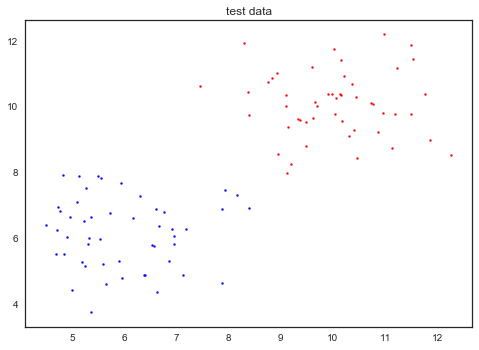

In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn import mixture

import re
import numpy as np
#-------------   data parameters
K = 2 #number of components
N = 100 #number of observations
M = 2 #number of attributes per observation

n_samples = int(N/2.0) #number of points in each component
mu1 = np.array([10, 10]) #mean of component 1
mu2 = np.array([6, 6]) #mean of component 1

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on mu1
comp1 = np.random.randn(n_samples, M) + mu1

# generate spherical data centered on mu2
comp2 = np.random.randn(N - n_samples, M) + mu2

# concatenate the two datasets into training set
data = np.vstack([comp1, comp2])

#plot the components
plt.scatter(comp1[:, 0], comp1[:, 1], 4, color='r')
plt.scatter(comp2[:, 0], comp2[:, 1], 4, color='b')

plt.title('test data')
plt.axis('tight')
plt.show()

In [2]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

# It would be easier to debug if we implement each update separately
def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covariancematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1)
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)
    
    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """Returns a k-element vector describing number of elements in each cluster"""
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    pi: a vector of K scalars
    """
    N_k = update_N_k(Z)
    pi = dirichlet.rvs(alpha_k+N_k)
    return np.squeeze(pi)

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mu_k: Vector of k elements, each element has a vector with D elements
    """
    #print m_k
    #print V_k
    mu_k = np.empty(len(m_k), dtype = object)
    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])
    return mu_k

def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    """
    V_k = np.empty(len(N_k), dtype = object)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)       
        
        
    return V_k

def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros(len(N_k), dtype = object)
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k


def update_mean_x_k(Z, X, N_k):
    """
    Average value of observations belonging to cluster k
    mean_x_k: Matrix of dimension KxD
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):                        
            mean_x_k[i]+=Z[j]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices
    """
    Sigma_k = np.empty(len(nu_k), dtype = object)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Scale matrices for inverse wishart distribution
    Returns array of k matrices (DxD)
    """
    S_k = np.empty(len(mu_k), dtype =object)
    for j in range(len(mu_k)):
        S_k[j]=S_0
        for i in range(len(Z)):
            print (X[i]-mu_k[j])
            print np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
            print Z[i][j]
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_nu_k(nu_0, N_k):
    """
    returns a k-element vector
    """

    nu_k = nu_0+N_k

    return nu_k

# this function can be reused even when we change the prior on pi 
def gibbs_gmm(K, X, pi, Z, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    """
    samples = np.zeros((500,10),dtype = object)
    #initialize everything
    V_k_start = np.empty(K, dtype = object)
    m_k_start = np.empty(K, dtype = object)   
    S_k_start = np.empty(K, dtype = object)   

    for i in range(K):
        V_k_start[i] = np.copy(V_0)
        m_k_start[i] = np.copy(m_0)
        S_k_start[i] = np.copy(S_0)
        
    samples[0][0] = update_mu_k(m_k_start, V_k_start)
    samples[0][1] = update_S_k(Z, X, samples[0][0], S_0)
    samples[0][2] = update_Sigma_k(samples[0][1], nu_0*np.ones(K))
    samples[0][3] = update_pi(alpha_0, Z)
    samples[0][4] = update_Z(X, samples[0][0], samples[0][2], samples[0][3])
    samples[0][5] = update_N_k(samples[0][4])
    samples[0][6] = update_nu_k(nu_0, samples[0][5])
    samples[0][7]= update_V_k(V_0, samples[0][5], samples[0][2])
    samples[0][8] = update_mean_x_k(Z, X, samples[0][5])
    samples[0][9] = update_m_k(samples[0][7], samples[0][2], samples[0][5], samples[0][8], V_0, m_0)
    
    for i in range(1,len(samples-1)):
        print "+++"
        print i
        samples[i][0] = update_mu_k(samples[i-1][9], samples[i-1][7])
        samples[i][1] = update_S_k(Z, X, samples[i][0], S_0)
        samples[i][2] = update_Sigma_k(samples[i][1], samples[i-1][6])
        samples[i][3] = update_pi(alpha_0, Z)
        samples[i][4] = update_Z(X, samples[i][0], samples[i][2], samples[i][3])
        samples[i][5] = update_N_k(samples[i][4])
        samples[i][6] = update_nu_k(nu_0, samples[i][5])
        samples[i][7]= update_V_k(V_0, samples[i][5], samples[i][2])
        samples[i][8] = update_mean_x_k(Z, X, samples[i][5])
        samples[i][9] = update_m_k(samples[i][7], samples[i][2], samples[i][5], samples[i][8], V_0, m_0)
    
    return samples


In [ ]:
N = 100
K = 2
X = data
pi = np.array([0.5, 0.5])
Z = np.zeros((N,K))
for i in range(N):
    if np.random.uniform()<0.5:
        Z[i,0] = 1
    else:
        Z[i,1] = 1
mu = np.array([[7.5, 11.2],[3.4, 7.6]]) 
Sigma = np.array([np.eye(2), np.eye(2)])
nu_0 = 3
S_0 = np.array([[1.2, 0.5], [0.2, 1.7]])
V_0 =  np.eye(2)
m_0 = np.array([7.5, 11.2])  
alpha_0 = np.array([0.5, 0.5])



samples = gibbs_gmm(K, X, pi, Z, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0)



[ 3.77031057 -0.68373885]
[[ 14.21524178  -2.57790782]
 [ -2.57790782   0.46749882]]
0.0
[ 2.98499621  1.15699714]
[[ 8.91020235  3.45363207]
 [ 3.45363207  1.33864238]]
1.0
[ 3.87381621 -2.06117394]
[[ 15.00645205  -7.98460903]
 [ -7.98460903   4.24843801]]
1.0
[ 2.95634664 -1.23525327]
[[ 8.73998546 -3.65183685]
 [-3.65183685  1.52585064]]
1.0
[ 1.90303937 -0.67329756]
[[ 3.62155885 -1.28131176]
 [-1.28131176  0.4533296 ]]
1.0
[ 2.15030179  0.37037745]
[[ 4.6237978   0.79642329]
 [ 0.79642329  0.13717945]]
0.0
[ 2.76729595 -0.96222104]
[[ 7.65792686 -2.6627504 ]
 [-2.6627504   0.92586934]]
0.0
[ 2.45012146 -0.75022173]
[[ 6.00309515 -1.83813437]
 [-1.83813437  0.56283265]]
0.0
[ 3.5003373  -1.28905432]
[[ 12.25236118  -4.51212493]
 [ -4.51212493   1.66166105]]
1.0
[ 2.31932592 -1.9379918 ]
[[ 5.37927274 -4.49483462]
 [-4.49483462  3.75581222]]
0.0
[-0.54673159 -0.43027747]
[[ 0.29891543  0.23524628]
 [ 0.23524628  0.1851387 ]]
1.0
[ 2.87069442 -1.82606108]
[[ 8.24088646 -5.24206336]


In [13]:
mu_k = np.empty(len(m_k), dtype = object)
for i in range(len(mu_k)):
    mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

array([[4, 2, 2, 4, 3, 5]])

In [17]:
update_Sigma_k(S_k, nu_k)

array([[ 0.44093628,  0.1883568 ],
       [ 0.1883568 ,  0.47185616]])

In [20]:
print S_0

[[ 1.  0.]
 [ 0.  1.]]


In [31]:
np.outer(np.array([1,0]),np.array([1,0]))

array([[1, 0],
       [0, 0]])

In [55]:
update_pi(alpha_0, Z)

array([[ 0.46725418,  0.53274582]])

In [91]:
 np.sum(Z, axis = 0)

array([ 44.,  56.])